# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # . .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import random
import torch
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

# This starts from the current working directory
# and goes up until it finds the 'fogas_torch' folder or '.git'
def find_root(current_path, marker="fogas_torch"):
    current_path = Path(current_path).resolve()
    for parent in [current_path] + list(current_path.parents):
        if (parent / marker).exists():
            return parent
    return current_path

PROJECT_ROOT = find_root(Path.cwd())
print(f"Project root found at: {PROJECT_ROOT}")

# Add project root to sys.path so we can import local packages
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Now define the dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_RBF.csv"
print(f"Loading dataset from: {DATASET_PATH}")

from fogas_torch import PolicySolver, EnvDataCollector
from fogas_torch.algorithm import (
    FOGASSolverVectorized,
    FOGASOracleSolverVectorized,
    FOGASHyperOptimizer,
    FOGASEvaluator,
    FOGASDataset,
)
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer
from fogas_torch.fqi.fqi_solver import FQISolver
from fogas_torch.fqi.fqi_evaluator import FQIEvaluator

seed = 42
np.random.seed(seed) # Add this
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Project root found at: /shared/home/mauro.diaz/work/FOGAS
Loading dataset from: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_RBF.csv
Using device: cuda


# RBF Features

## With goal - pit condition feature

In [ ]:
# ===== 10x10 Four-Rooms Grid Configuration =====
states  = torch.arange(100, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N, A = 100, 4
gamma = 0.9
goal = 99
pits = {18, 32, 57, 61, 75}
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

from sklearn.cluster import KMeans

# -----------------------------------------------------------------------
# Shared Helpers
# -----------------------------------------------------------------------
def get_norm_coords(s):
    r, c = divmod(int(s), 10)
    return torch.tensor([r / 9.0, c / 9.0], dtype=torch.float64)

def calculate_local_sigma(centers, k=2):
    """
    Computes sigma based on the k-nearest neighbors.
    This is much better for FOGAS in environments with walls.
    """
    dist_matrix = torch.cdist(centers, centers, p=2)
    # topk(k+1) because the closest point is always the point itself (dist=0)
    topk_dists, _ = torch.topk(dist_matrix, k + 1, largest=False, dim=1)
    # Use the distance to the 1st nearest neighbor (index 1 skips self at 0)
    nearest_neighbor_dists = topk_dists[:, 1]
    return torch.mean(nearest_neighbor_dists)

def calculate_median_sigma(centers):
    """Median Trick: sigma = median of all pairwise distances."""
    dist_matrix = torch.cdist(centers, centers, p=2)
    indices = torch.triu_indices(len(centers), len(centers), offset=1)
    pairwise_distances = dist_matrix[indices[0], indices[1]]
    return torch.median(pairwise_distances)

# -----------------------------------------------------------------------
# MDP 1 — 30 KMeans centers + bias + indicators (is_pit, is_goal)
# -----------------------------------------------------------------------
def get_kmeans_centers(num_centers=25):
    """K-Means on all non-wall states (normalized coords)."""
    valid_coords = []
    for s in range(100):
        if s not in walls:
            r, c = divmod(s, 10)
            valid_coords.append([r / 9.0, c / 9.0])
    kmeans = KMeans(n_clusters=num_centers, n_init=10, random_state=42).fit(valid_coords)
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

num_rbf_centers = 30
centers   = get_kmeans_centers(num_centers=num_rbf_centers)
rbf_sigma = calculate_local_sigma(centers, k=2)

def phi_state(x):
    coords  = get_norm_coords(x)
    dist_sq = torch.sum((coords - centers)**2, dim=1)
    rbf     = torch.exp(-dist_sq / (2 * rbf_sigma**2))
    is_pit  = 1.0 if int(x) in pits else 0.0
    is_goal = 1.0 if int(x) == goal else 0.0
    indicators = torch.tensor([is_pit, is_goal], dtype=torch.float64)
    return torch.cat([rbf, torch.ones(1, dtype=torch.float64), indicators])

def phi(x, a):
    """Coupled Feature Map: phi(x, a) = e_a ⊗ phi_state(x)."""
    s_feat = phi_state(x)
    e_a    = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d = int(phi(states[0], actions[0]).shape[0])

# -----------------------------------------------------------------------
# Reward function and Transition Matrix (shared by both MDPs)
# -----------------------------------------------------------------------
def reward_fn(x, a):
    x_int = int(x)
    if x_int == goal:   return  1.0
    if x_int in pits:   return -5.0
    return -0.1

P = torch.zeros((N * A, N), dtype=torch.float64)
for x in range(N):
    for a in range(A):
        if x in pits or x == goal:
            P[x * A + a, x] = 1.0
            continue
        r, c = divmod(x, 10)
        if   a == 0: r_next, c_next = max(0, r-1), c
        elif a == 1: r_next, c_next = min(9, r+1), c
        elif a == 2: r_next, c_next = r, max(0, c-1)
        elif a == 3: r_next, c_next = r, min(9, c+1)
        next_state = r_next * 10 + c_next
        if next_state in walls:
            next_state = x
        P[x * A + a, next_state] = 1.0

# ---------- Create MDP 1 ----------
mdp = PolicySolver(
    states=states, actions=actions, phi=phi,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

MDP2: 35 free centers + 6 anchor centers = 41 total
  sigma_global = 0.1301
  sigma_anchor = 0.0325  (scale=0.25)
  d2 = A * (K + bias) = 4 * (41 + 1) = 168


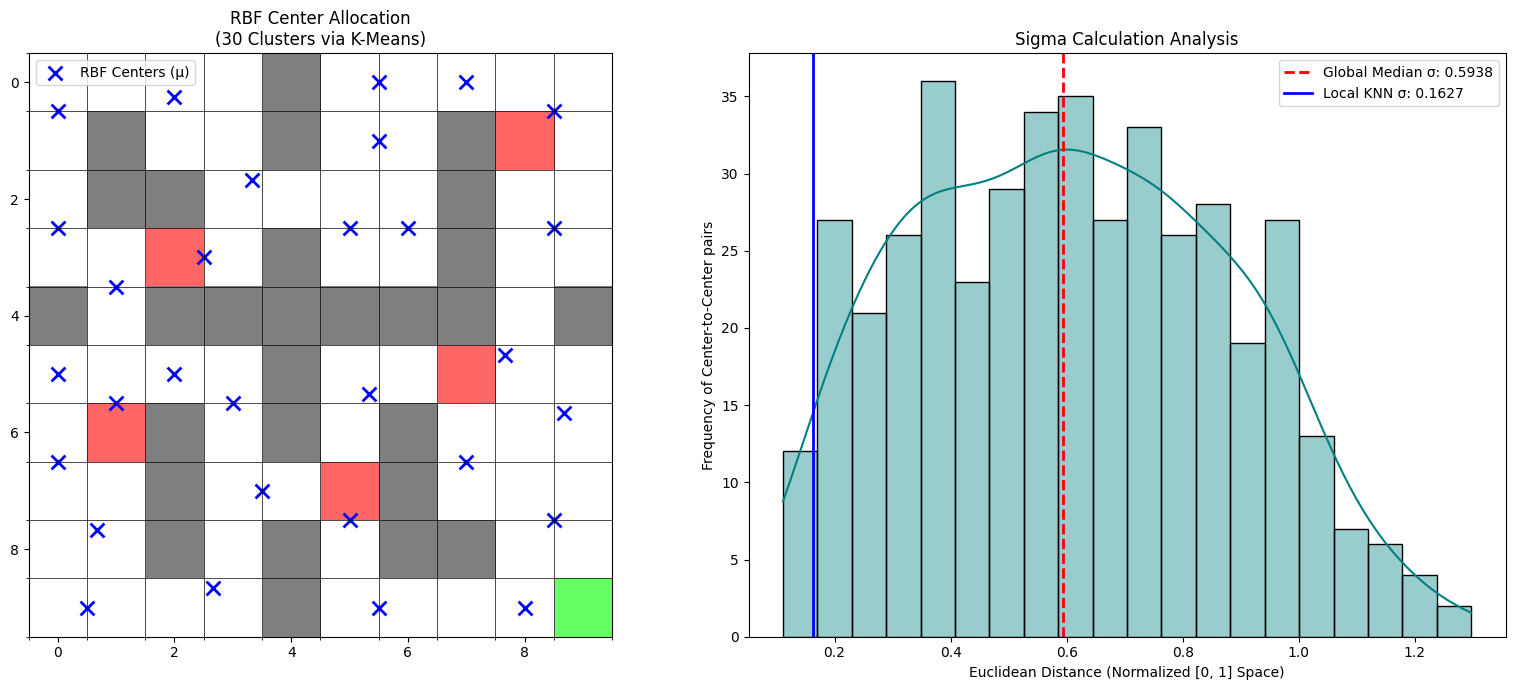

Metric                    | Value     
----------------------------------------
Global Median Sigma       | 0.593821
Local KNN Sigma (k=2)     | 0.162732
Difference (%)            | 72.60%
----------------------------------------
RATIONALE:
1. Global Median: Better for 'Smoothing'—covers the whole range of distances.
2. Local KNN: Better for 'Precision'—ensures centers only overlap with their
   immediate neighbors, preventing blurry feature activations across rooms.


In [17]:
def visualize_rbf_analysis(centers, walls, pits, goal):
    # 1. Compute both Sigmas
    sigma_median = calculate_median_sigma(centers).item()
    sigma_local = calculate_local_sigma(centers, k=2).item()
    
    # --- PLOT 1: Spatial Grid Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    grid_display = np.ones((10, 10, 3)) 
    for s in range(100):
        r, c = divmod(s, 10)
        if s in walls: grid_display[r, c] = [0.5, 0.5, 0.5]
        elif s in pits: grid_display[r, c] = [1.0, 0.4, 0.4]
        elif s == goal: grid_display[r, c] = [0.4, 1.0, 0.4]

    ax1.imshow(grid_display, origin='upper')
    centers_np = centers.numpy() * 9.0
    ax1.scatter(centers_np[:, 1], centers_np[:, 0], 
                color='blue', marker='x', s=100, label='RBF Centers (μ)', linewidths=2)
    
    ax1.set_xticks(np.arange(-0.5, 10, 1), minor=True); ax1.set_yticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax1.set_title(f"RBF Center Allocation\n(30 Clusters via K-Means)")
    ax1.legend()

    # --- PLOT 2: Sigma Distribution Analysis ---
    dist_matrix = torch.cdist(centers, centers, p=2)
    indices = torch.triu_indices(len(centers), len(centers), offset=1)
    pairwise_distances = dist_matrix[indices[0], indices[1]].numpy()
    
    sns.histplot(pairwise_distances, kde=True, color='teal', bins=20, ax=ax2, alpha=0.4)
    ax2.axvline(sigma_median, color='red', linestyle='--', linewidth=2, 
                label=f'Global Median σ: {sigma_median:.4f}')
    ax2.axvline(sigma_local, color='blue', linestyle='-', linewidth=2, 
                label=f'Local KNN σ: {sigma_local:.4f}')
    
    ax2.set_title("Sigma Calculation Analysis")
    ax2.set_xlabel("Euclidean Distance (Normalized [0, 1] Space)")
    ax2.set_ylabel("Frequency of Center-to-Center pairs")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # --- Print Stats Table ---
    print(f"{'Metric':<25} | {'Value':<10}")
    print("-" * 40)
    print(f"{'Global Median Sigma':<25} | {sigma_median:.6f}")
    print(f"{'Local KNN Sigma (k=2)':<25} | {sigma_local:.6f}")
    print(f"{'Difference (%)':<25} | {abs(sigma_median-sigma_local)/sigma_median*100:.2f}%")
    print("-" * 40)
    print(f"RATIONALE:")
    print(f"1. Global Median: Better for 'Smoothing'—covers the whole range of distances.")
    print(f"2. Local KNN: Better for 'Precision'—ensures centers only overlap with their")
    print(f"   immediate neighbors, preventing blurry feature activations across rooms.")

# Run the visualizer
visualize_rbf_analysis(centers, walls, pits, goal)

### Dataset creation

In [ ]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_rbf",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.3)

collector.collect_mixed_dataset_terminal_aware(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=8000, #10000,
    episode_based=True,                   
    save_path=str(DATASET_PATH),
    verbose=True,
    extra_steps=3  # The 3 extra steps
)


  MIXED TERMINAL-AWARE DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 8000
Total episodes: 221
Extra steps: 3

Policy Distribution:
  Policy 0:  5995 steps (74.9%) | Target: 80.0% | Episodes: 176
  Policy 1:  2005 steps (25.1%) | Target: 20.0% | Episodes: 46

✅ Mixed terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_RBF.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,3,-0.1,1,0
2,0,2,1,3,-0.1,2,0
3,0,3,2,1,-0.1,12,0
4,0,4,12,3,-0.1,13,0
...,...,...,...,...,...,...,...
7995,221,9,23,3,-0.1,24,0
7996,221,10,24,3,-0.1,25,0
7997,221,11,25,2,-0.1,24,0
7998,221,12,24,3,-0.1,25,0


In [6]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_rbf",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.2)

collector.collect_mixed_dataset_terminal_aware(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=40000,
    episode_based=True,                   
    save_path=str(DATASET_PATH3),
    verbose=True,
    extra_steps=5  # The 3 extra steps
)


  MIXED TERMINAL-AWARE DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 40000
Total episodes: 1139
Extra steps: 5

Policy Distribution:
  Policy 0: 30488 steps (76.2%) | Target: 80.0% | Episodes: 917
  Policy 1:  9512 steps (23.8%) | Target: 20.0% | Episodes: 223

✅ Mixed terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_rbf_try.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,3,-0.1,1,0
1,0,1,1,3,-0.1,2,0
2,0,2,2,1,-0.1,12,0
3,0,3,12,3,-0.1,13,0
4,0,4,13,1,-0.1,23,0
...,...,...,...,...,...,...,...
39995,1139,11,23,0,-0.1,13,0
39996,1139,12,13,1,-0.1,23,0
39997,1139,13,23,3,-0.1,24,0
39998,1139,14,24,3,-0.1,25,0


### Solving it


     REWARD APPROXIMATION ANALYSIS
Metric                                Value
────────────────────────────────────────────
Max |error|                        0.023683
Mean |error|                       0.002008
RMSE                               0.004334
R² (explained variance)            0.999985

--------------------------------------------------
State  Action         r_true      r_hat      error
──────────────────────────────────────────────────
0            ↑ Up          -0.1000    -0.0999     0.0001
0            ↓ Down        -0.1000    -0.1000     0.0000
0            ← Left        -0.1000    -0.0999     0.0001
0            → Right       -0.1000    -0.1000     0.0000
1            ↑ Up          -0.1000    -0.1001    -0.0001
1            ↓ Down        -0.1000    -0.1000    -0.0000
1            ← Left        -0.1000    -0.1001    -0.0001
1            → Right       -0.1000    -0.1000    -0.0000
2            ↑ Up          -0.1000    -0.0999     0.0001
2            ↓ Down        -0.10

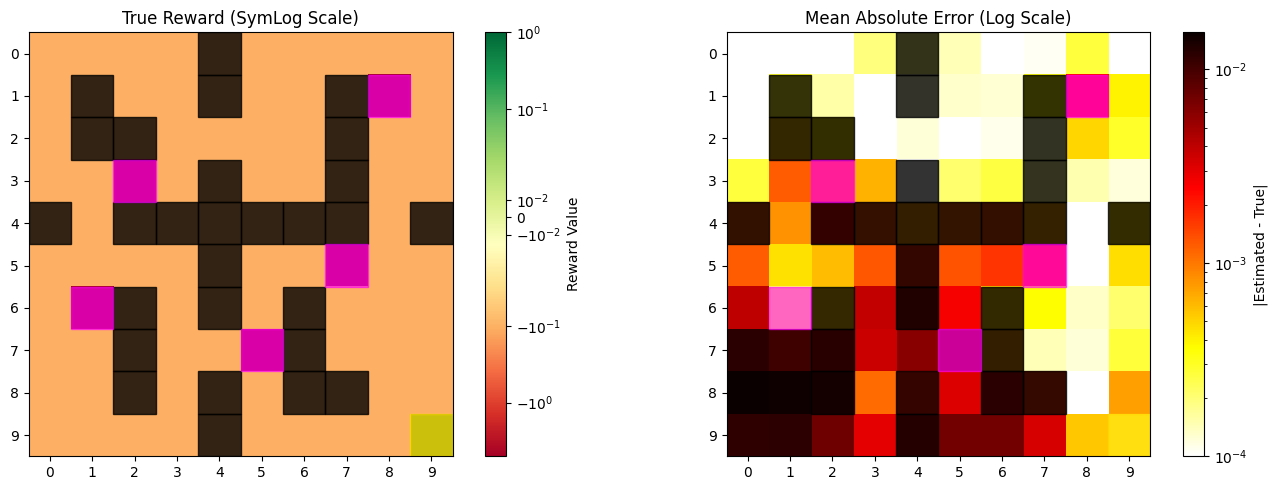

In [ ]:
solver_e = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


evaluator_e.analyze_reward_approximation(
    walls=walls, 
    pits=pits, 
    goal=goal
)

In [161]:
# Run solver with best alpha and fixed rho, eta
solver_e.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=13000)
evaluator_e.print_policy()

FOGAS:   1%|█                                                                                      | 161/13000 [00:00<00:08, 1603.59it/s]

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████| 13000/13000 [00:07<00:00, 1699.11it/s]


  State 0: π(a=0|s=0) = 0.17  π(a=1|s=0) = 0.19  π(a=2|s=0) = 0.15  π(a=3|s=0) = 0.49  --> best action: 3
  State 1: π(a=0|s=1) = 0.12  π(a=1|s=1) = 0.09  π(a=2|s=1) = 0.06  π(a=3|s=1) = 0.73  --> best action: 3
  State 2: π(a=0|s=2) = 0.18  π(a=1|s=2) = 0.27  π(a=2|s=2) = 0.08  π(a=3|s=2) = 0.47  --> best action: 3
  State 3: π(a=0|s=3) = 0.18  π(a=1|s=3) = 0.61  π(a=2|s=3) = 0.06  π(a=3|s=3) = 0.15  --> best action: 1
  State 4: π(a=0|s=4) = 0.18  π(a=1|s=4) = 0.45  π(a=2|s=4) = 0.04  π(a=3|s=4) = 0.33  --> best action: 1
  State 5: π(a=0|s=5) = 0.09  π(a=1|s=5) = 0.05  π(a=2|s=5) = 0.01  π(a=3|s=5) = 0.85  --> best action: 3
  State 6: π(a=0|s=6) = 0.08  π(a=1|s=6) = 0.01  π(a=2|s=6) = 0.03  π(a=3|s=6) = 0.88  --> best action: 3
  State 7: π(a=0|s=7) = 0.14  π(a=1|s=7) = 0.05  π(a=2|s=7) = 0.10  π(a=3|s=7) = 0.71  --> best action: 3
  State 8: π(a=0|s=8) = 0.12  π(a=1|s=8) = 0.41  π(a=2|s=8) = 0.02  π(a=3|s=8) = 0.44  --> best action: 3
  State 9: π(a=0|s=9) = 0.04  π(a=1|s=9) = 0.9

In [162]:
evaluator_e.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7    

## Only RBF features

In [28]:
# -----------------------------------------------------------------------
# MDP 2 — Anchored RBFs: KMeans free centers + explicit goal/pit centers
#          Free centers  → global KNN sigma
#          Anchor centers → small local sigma  (sharply localized)
#          No indicator features — only pure RBFs
# -----------------------------------------------------------------------
def get_anchored_centers(num_free_centers=35, anchor_states=None):
    """
    Returns:
        all_centers  : (num_free + num_anchors, 2) tensor
        n_free       : number of free K-Means centers
        n_anchors    : number of anchor centers
        
    Free centers   → K-Means on states that are NOT walls and NOT anchors.
    Anchor centers → placed exactly at the target states (goal, pits).
    """
    anchor_states = set(anchor_states or [])

    # Free center pool: exclude walls AND anchors so K-Means doesn't
    # accidentally absorb the anchor positions into generic centers
    valid_coords = []
    for s in range(100):
        if s not in walls and s not in anchor_states:
            r, c = divmod(s, 10)
            valid_coords.append([r / 9.0, c / 9.0])

    kmeans       = KMeans(n_clusters=num_free_centers, n_init=10, random_state=42).fit(valid_coords)
    free_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

    # Anchor centers placed exactly at the special states (sorted for reproducibility)
    anchor_coords = [[divmod(s, 10)[0] / 9.0, divmod(s, 10)[1] / 9.0]
                     for s in sorted(anchor_states)]
    anchor_centers = torch.tensor(anchor_coords, dtype=torch.float64)

    all_centers = torch.cat([free_centers, anchor_centers], dim=0)
    return all_centers, len(free_centers), len(anchor_centers)


# Hyperparameters for MDP 2
num_free_centers2 = 35                        # free K-Means centers (non-wall, non-anchor)
anchor_states2    = {goal} | pits             # goal + all 5 pits
sigma_scale       = 0.25                      # anchor sigma = global_sigma * scale
                                              # → activation at nearest neighbor ≈ exp(-1/8σ)
                                              # small enough to avoid bleeding

centers2, n_free2, n_anchors2 = get_anchored_centers(
    num_free_centers=num_free_centers2,
    anchor_states=anchor_states2,
)

# Sigma for free centers: KNN on the full center set (includes anchors → conservative)
sigma_global2 = calculate_local_sigma(centers2, k=3) * 1.5

# Sigma for anchor centers: much smaller → sharply localized basis functions
sigma_anchor2 = sigma_global2 * sigma_scale

# Per-center sigma vector: (K,)
sigmas2 = torch.full((len(centers2),), sigma_global2, dtype=torch.float64)
sigmas2[n_free2:] = sigma_anchor2            # override for the last n_anchors entries

print(f"MDP2: {n_free2} free centers + {n_anchors2} anchor centers = {len(centers2)} total")
print(f"  sigma_global = {sigma_global2:.4f}")
print(f"  sigma_anchor = {sigma_anchor2:.4f}  (scale={sigma_scale})")
print(f"  d2 = A * (K + bias) = {A} * ({len(centers2)} + 1) = {A * (len(centers2) + 1)}")


def phi_state2(x):
    """
    Pure RBF features with per-center sigma.
    Free centers  use sigma_global2 → smooth spatial generalization.
    Anchor centers use sigma_anchor2 → sharp, localized reward isolation.
    No indicator features needed.
    """
    coords  = get_norm_coords(x)
    dist_sq = torch.sum((coords - centers2)**2, dim=1)      # (K,)
    rbf     = torch.exp(-dist_sq / (2 * sigmas2**2))        # (K,) — per-center sigma
    return torch.cat([rbf, torch.ones(1, dtype=torch.float64)])   # +bias

def phi2(x, a):
    """Coupled Feature Map: phi2(x, a) = e_a ⊗ phi_state2(x)."""
    s_feat      = phi_state2(x)
    e_a         = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d2 = int(phi2(states[0], actions[0]).shape[0])

# ---------- Create MDP 2 ----------
mdp2 = PolicySolver(
    states=states, actions=actions, phi=phi2,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

MDP2: 35 free centers + 6 anchor centers = 41 total
  sigma_global = 0.1952
  sigma_anchor = 0.0488  (scale=0.25)
  d2 = A * (K + bias) = 4 * (41 + 1) = 168


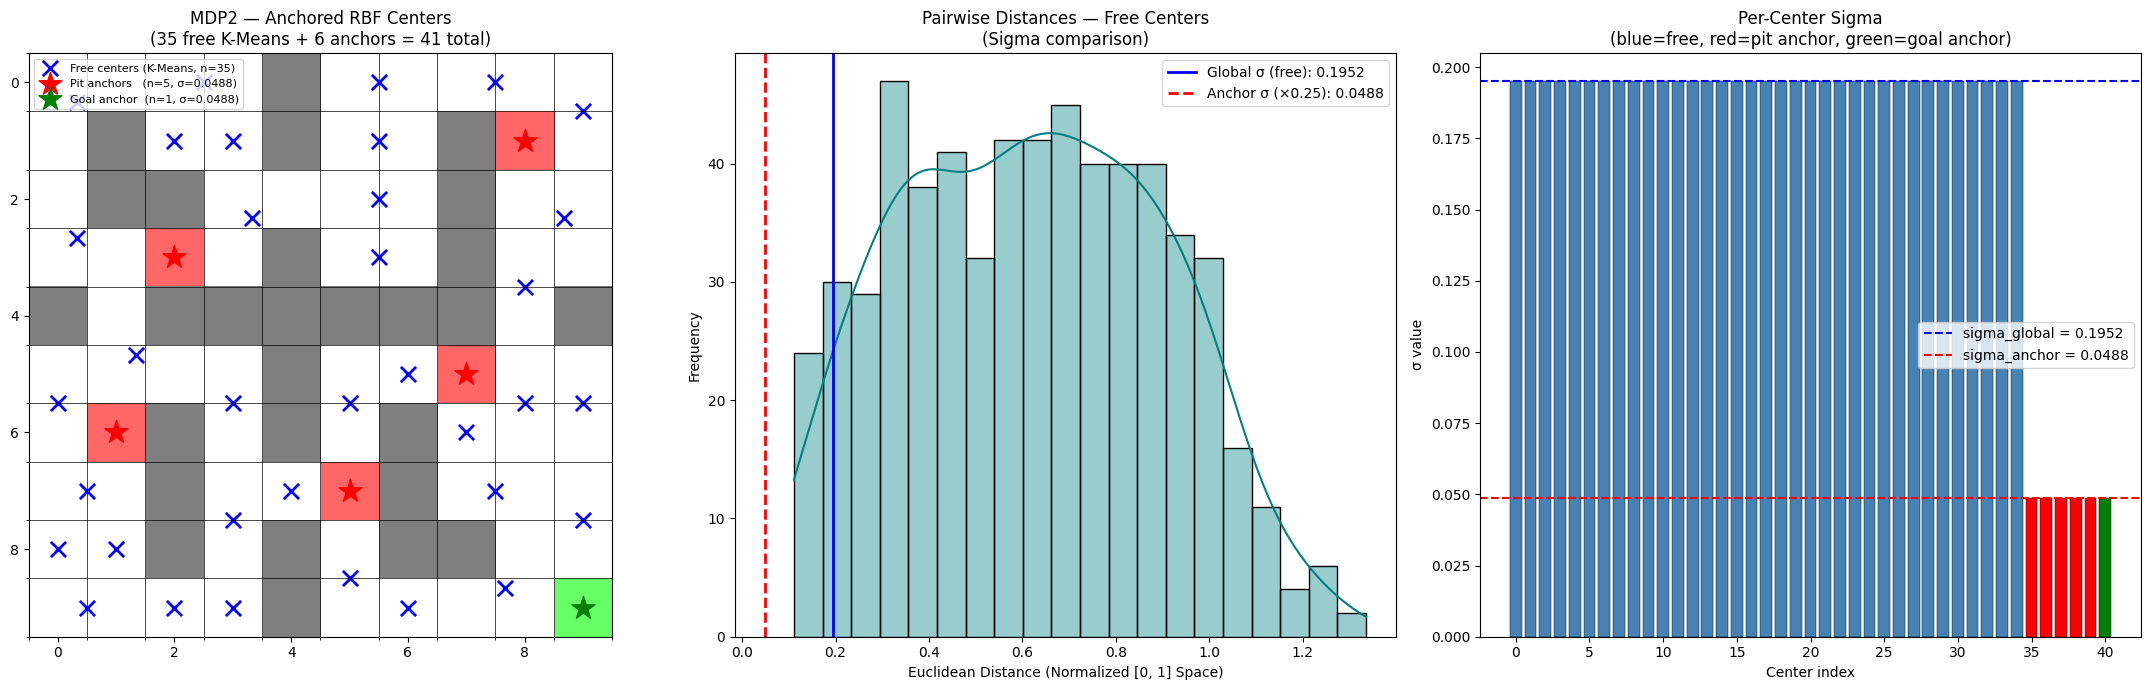

Metric                              | Value       
----------------------------------------------------
Total centers                       | 41
  Free (K-Means)                    | 35
  Anchors (goal + pits)             | 6
Global sigma (free centers)         | 0.195153
Anchor sigma                        | 0.048788
Sigma scale (anchor/global)         | 0.25×
Feature dim d2                      | 168
----------------------------------------------------
RATIONALE (MDP2 anchored design):
  Free centers  → KNN sigma → smooth spatial generalization across rooms
  Anchor centers → small sigma → sharp, isolated activation at goal/pits
  → omega regression can assign large weights to anchors without bleeding


In [29]:
def visualize_rbf_analysis2(centers2, n_free, sigmas2, sigma_global, sigma_anchor,
                              walls, pits, goal):
    """
    Visualization for the anchored RBF setup of mdp2.
    - Free centers (K-Means)  → blue  crosses, sigma_global
    - Anchor centers (goal/pits) → star markers, sigma_anchor (small)
    """
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))

    # ------------------------------------------------------------------ #
    # PLOT 1: Spatial Grid — free vs anchor centers
    # ------------------------------------------------------------------ #
    ax1 = axes[0]
    grid_display = np.ones((10, 10, 3))
    for s in range(100):
        r, c = divmod(s, 10)
        if s in walls:     grid_display[r, c] = [0.5, 0.5, 0.5]
        elif s in pits:    grid_display[r, c] = [1.0, 0.4, 0.4]
        elif s == goal:    grid_display[r, c] = [0.4, 1.0, 0.4]

    ax1.imshow(grid_display, origin='upper')

    centers2_np = centers2.numpy() * 9.0

    # Free centers
    ax1.scatter(centers2_np[:n_free, 1], centers2_np[:n_free, 0],
                color='blue', marker='x', s=120, linewidths=2,
                label=f'Free centers (K-Means, n={n_free})')

    # Anchor centers — split goal vs pits for clarity
    n_anchors = len(centers2) - n_free
    anchor_coords = centers2_np[n_free:]

    # The anchors are sorted by state index: pits first (sorted), then goal
    # (matches how we built them: for s in sorted(anchor_states))
    anchor_states_sorted = sorted(pits | {goal})
    pit_mask  = [s != goal for s in anchor_states_sorted]
    goal_mask = [s == goal for s in anchor_states_sorted]

    pit_coords  = anchor_coords[[i for i, m in enumerate(pit_mask)  if m]]
    goal_coords = anchor_coords[[i for i, m in enumerate(goal_mask) if m]]

    ax1.scatter(pit_coords[:, 1],  pit_coords[:, 0],
                color='red',   marker='*', s=300, zorder=5,
                label=f'Pit anchors   (n={sum(pit_mask)}, σ={sigma_anchor:.4f})')
    ax1.scatter(goal_coords[:, 1], goal_coords[:, 0],
                color='green', marker='*', s=300, zorder=5,
                label=f'Goal anchor  (n=1, σ={sigma_anchor:.4f})')

    ax1.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax1.set_title(f"MDP2 — Anchored RBF Centers\n"
                  f"({n_free} free K-Means + {n_anchors} anchors = {len(centers2)} total)")
    ax1.legend(loc='upper left', fontsize=8)

    # ------------------------------------------------------------------ #
    # PLOT 2: Pairwise distance distribution of FREE centers only
    # ------------------------------------------------------------------ #
    ax2 = axes[1]
    free_centers = centers2[:n_free]
    dist_matrix  = torch.cdist(free_centers, free_centers, p=2)
    idx          = torch.triu_indices(n_free, n_free, offset=1)
    pw_dists     = dist_matrix[idx[0], idx[1]].numpy()

    sns.histplot(pw_dists, kde=True, color='teal', bins=20, ax=ax2, alpha=0.4)
    ax2.axvline(sigma_global, color='blue', linestyle='-', linewidth=2,
                label=f'Global σ (free): {sigma_global:.4f}')
    ax2.axvline(sigma_anchor, color='red',  linestyle='--', linewidth=2,
                label=f'Anchor σ (×{sigma_anchor/sigma_global:.2f}): {sigma_anchor:.4f}')
    ax2.set_title("Pairwise Distances — Free Centers\n(Sigma comparison)")
    ax2.set_xlabel("Euclidean Distance (Normalized [0, 1] Space)")
    ax2.set_ylabel("Frequency")
    ax2.legend()

    # ------------------------------------------------------------------ #
    # PLOT 3: Per-center sigma bar chart
    # ------------------------------------------------------------------ #
    ax3 = axes[2]
    sigmas_np = sigmas2.numpy()
    colors    = ['steelblue'] * n_free + ['red' if s != goal else 'green'
                                           for s in anchor_states_sorted]
    ax3.bar(range(len(sigmas_np)), sigmas_np, color=colors, edgecolor='black', linewidth=0.3)
    ax3.axhline(sigma_global, color='blue',  linestyle='--', linewidth=1.5,
                label=f'sigma_global = {sigma_global:.4f}')
    ax3.axhline(sigma_anchor, color='red',   linestyle='--', linewidth=1.5,
                label=f'sigma_anchor = {sigma_anchor:.4f}')
    ax3.set_title("Per-Center Sigma\n(blue=free, red=pit anchor, green=goal anchor)")
    ax3.set_xlabel("Center index")
    ax3.set_ylabel("σ value")
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------ #
    # Stats table
    # ------------------------------------------------------------------ #
    print(f"{'Metric':<35} | {'Value':<12}")
    print("-" * 52)
    print(f"{'Total centers':<35} | {len(centers2)}")
    print(f"{'  Free (K-Means)':<35} | {n_free}")
    print(f"{'  Anchors (goal + pits)':<35} | {len(centers2) - n_free}")
    print(f"{'Global sigma (free centers)':<35} | {sigma_global:.6f}")
    print(f"{'Anchor sigma':<35} | {sigma_anchor:.6f}")
    print(f"{'Sigma scale (anchor/global)':<35} | {sigma_anchor/sigma_global:.2f}×")
    print(f"{'Feature dim d2':<35} | {d2}")
    print("-" * 52)
    print("RATIONALE (MDP2 anchored design):")
    print("  Free centers  → KNN sigma → smooth spatial generalization across rooms")
    print("  Anchor centers → small sigma → sharp, isolated activation at goal/pits")
    print("  → omega regression can assign large weights to anchors without bleeding")

# Run
visualize_rbf_analysis2(
    centers2=centers2,
    n_free=n_free2,
    sigmas2=sigmas2,
    sigma_global=sigma_global2.item(),
    sigma_anchor=sigma_anchor2.item(),
    walls=walls,
    pits=pits,
    goal=goal,
)


### Dataset creation

In [20]:
DATASET_PATH2 = "/shared/home/mauro.diaz/work/FOGAS/datasets/10grid_rbf_try.csv"

In [ ]:
# Configure the probabilities: 
# 80% of trajectories start in a random "safe" state
# 20% of trajectories start in the fixed initial state (x0)
reset_options = {
    'random': 0.8, 
    'x0': 0.2
}

# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    restricted_states=walls,  # These will never be starting states
    terminal_states=list(pits) + (goal if isinstance(goal, list) else [goal]), # Terminal states are also excluded
    reset_probs=reset_options,
    max_steps=50
)

collector.collect_dataset_terminal_aware(
    n_steps=20000, extra_steps=5, save_path=str(DATASET_PATH2), verbose=True
)

In [21]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_rbf",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.2)

collector.collect_mixed_dataset_terminal_aware(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=15000,
    episode_based=True,                   
    save_path=str(DATASET_PATH2),
    verbose=True,
    extra_steps=5  # The 3 extra steps
)


  MIXED TERMINAL-AWARE DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 15000
Total episodes: 425
Extra steps: 5

Policy Distribution:
  Policy 0: 11428 steps (76.2%) | Target: 80.0% | Episodes: 345
  Policy 1:  3572 steps (23.8%) | Target: 20.0% | Episodes: 81

✅ Mixed terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_rbf_try.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,3,-0.1,1,0
1,0,1,1,3,-0.1,2,0
2,0,2,2,1,-0.1,12,0
3,0,3,12,3,-0.1,13,0
4,0,4,13,1,-0.1,23,0
...,...,...,...,...,...,...,...
14995,425,24,78,2,-0.1,77,0
14996,425,25,77,3,-0.1,78,0
14997,425,26,78,1,-0.1,88,0
14998,425,27,88,3,-0.1,89,0


### Solving it

[FOGASSolverVectorized] omega estimated via regression (beta_omega=4.29e-07, n=15000)

     REWARD APPROXIMATION ANALYSIS
Metric                                Value
────────────────────────────────────────────
Max |error|                        6.462720
Mean |error|                       0.214857
RMSE                               0.614735
R² (explained variance)            0.681987

--------------------------------------------------
State  Action         r_true      r_hat      error
──────────────────────────────────────────────────
0            ↑ Up          -0.1000    -0.1199    -0.0199
0            ↓ Down        -0.1000    -0.1661    -0.0661
0            ← Left        -0.1000    -0.1146    -0.0146
0            → Right       -0.1000    -0.1115    -0.0115
1            ↑ Up          -0.1000    -0.0824     0.0176
1            ↓ Down        -0.1000    -0.0240     0.0760
1            ← Left        -0.1000    -0.0813     0.0187
1            → Right       -0.1000    -0.0853     0.0147
2  

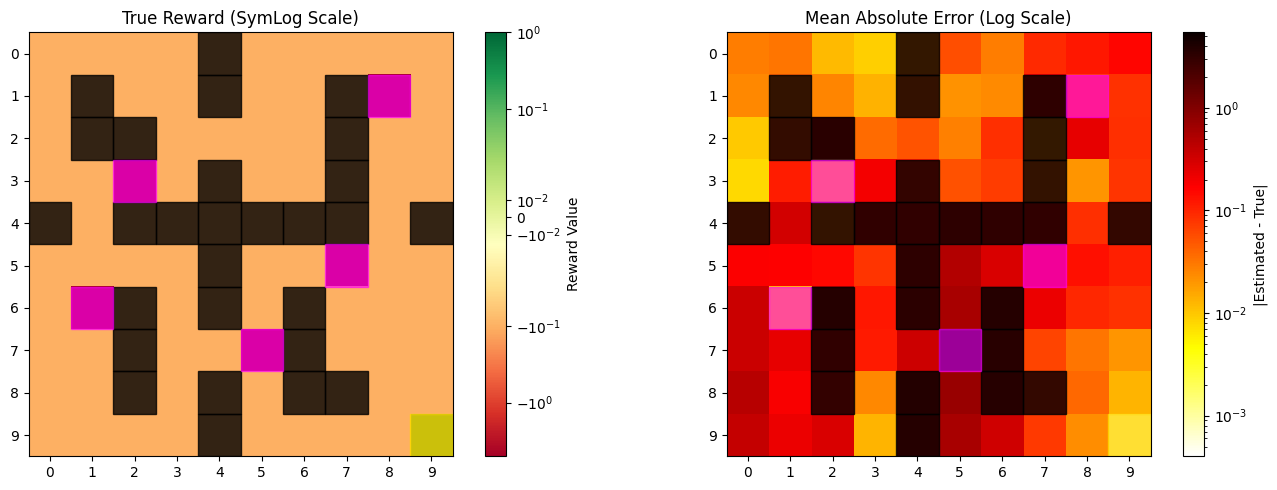

In [30]:
solver_e1 = FOGASSolverVectorized(
    mdp=mdp2,
    csv_path=str(DATASET_PATH2),
    device=device,
    seed=seed)
evaluator_e1 = FOGASEvaluator(solver_e1)
evaluator_e1.analyze_reward_approximation(
    walls=walls, 
    pits=pits, 
    goal=goal
)

In [31]:
# Run solver with best alpha and fixed rho, eta
solver_e1.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=13000)
evaluator_e1.print_policy()

evaluator_e1.print_optimal_path(goal_state=99)

FOGAS:   2%|█▉                                                                                                 | 258/13000 [00:00<00:14, 854.79it/s]

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13000/13000 [00:15<00:00, 847.89it/s]

  State 0: π(a=0|s=0) = 0.17  π(a=1|s=0) = 0.18  π(a=2|s=0) = 0.17  π(a=3|s=0) = 0.48  --> best action: 3
  State 1: π(a=0|s=1) = 0.11  π(a=1|s=1) = 0.19  π(a=2|s=1) = 0.07  π(a=3|s=1) = 0.64  --> best action: 3
  State 2: π(a=0|s=2) = 0.14  π(a=1|s=2) = 0.45  π(a=2|s=2) = 0.04  π(a=3|s=2) = 0.38  --> best action: 1
  State 3: π(a=0|s=3) = 0.16  π(a=1|s=3) = 0.60  π(a=2|s=3) = 0.02  π(a=3|s=3) = 0.22  --> best action: 1
  State 4: π(a=0|s=4) = 0.17  π(a=1|s=4) = 0.18  π(a=2|s=4) = 0.01  π(a=3|s=4) = 0.65  --> best action: 3
  State 5: π(a=0|s=5) = 0.05  π(a=1|s=5) = 0.01  π(a=2|s=5) = 0.00  π(a=3|s=5) = 0.94  --> best action: 3
  State 6: π(a=0|s=6) = 0.06  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 0.93  --> best action: 3
  State 7: π(a=0|s=7) = 0.19  π(a=1|s=7) = 0.06  π(a=2|s=7) = 0.04  π(a=3|s=7) = 0.71  --> best action: 3
  State 8: π(a=0|s=8) = 0.04  π(a=1|s=8) = 0.30  π(a=2|s=8) = 0.02  π(a=3|s=8) = 0.65  --> best action: 3
  State 9: π(a=0|s=9) = 0.02  π(a=1|s=9) = 0.9

# Data analysis

**What “alignment-based coverage” looks like in this tabular case**

FOGAS’ key coverage term is the **feature coverage ratio**
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2
$$
(and this measures how well the dataset covers the comparator policy in feature space). 

With one-hot features, the empirical covariance
$$
\Lambda_n = \beta I + \frac{1}{n}\sum_{i=1}^n \phi_i\phi_i^\top
$$
is **diagonal**, and each diagonal entry corresponds to a particular $(x,a)$:
$$
(\Lambda_n)_{(x,a),(x,a)} = \beta + \frac{N(x,a)}{n}.
$$
(Here $N(x,a)$ is how often $(x,a)$ appears in the dataset.) 

Because it’s diagonal, the coverage ratio becomes:
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2 =
\sum_{x,a}\frac{\mu_{\pi^*}(x,a)^2}{\beta + N(x,a)/n}.
$$

So **alignment-based coverage** (in tabular) literally means:

- The dataset counts $N(x,a)$ are large exactly on the $(x,a)$ where $\mu_{\pi^*}(x,a)$ is large.


In [67]:
analyzer = DatasetAnalyzer(DATASET_PATH)

ratio = analyzer.feature_coverage_ratio(
    mdp=mdp,
    use_optimal_policy=True,
    verbose=True,
    return_details=True,
)


Feature Coverage Ratio Details
------------------------------
  Dataset size (n):         12000
  MDP dims (N, A, d):        (100, 4, 92)
  gamma:                    0.9
  beta (ridge):             0
  policy source:            provided

  Occupancy μ_pi summary:
    sum:                    1
    min / max:              0 / 0.1

  Feature occupancy λ_pi summary:
    ||λ||_2:                0.888493
    ||λ||_1:                4.17106
    max |λ_i|:              0.521495

  Empirical covariance Λ_n:
    diag min / mean / max:  6.20146e-05 / 0.0313984 / 0.328667
    eig min / max:          3.82461e-07 / 0.644
    condition number:       1.68383e+06

  Coverage ratio:           1.79378


Let's check if the feature coverage ratio agrees with the dataset that we used and with the logic of more greedy will be better.

In [20]:
GRID_PATH = PROJECT_ROOT / "datasets" / "10x10_grid.csv"

In [ ]:
# Vary dataset sizes, exploration, policy proportions, and initial state distribution
dataset_sizes = [8000, 12000, 16000, 20000, 24000]
epsilon_values = [0.3, 0.4, 0.5, 0.6, 0.7]

# Policy proportions: [Epsilon-Greedy, Random]
proportion_configs = {
    "100/0": ([1.0, 0.0], "100% Eps-Greedy"),
    "90/10": ([0.9, 0.1], "90% Eps-Greedy / 10% Random"),
    "80/20": ([0.8, 0.2], "80% Eps-Greedy / 20% Random"),
    "70/30": ([0.7, 0.3], "70% Eps-Greedy / 30% Random"),
}

# Initial Start Point configurations
reset_configs = {
    "Fixed": {'custom': 1.0},
    "Random": {'random': 0.8, 'x0': 0.2}  # 80% random, 20% fixed start
}

# FOGAS Training Parameters (matching your previous best runs)
FOGAS_PARAMS = {
    'alpha': 0.001,
    'eta': 0.0002,
    'rho': 0.05,
    'T': 12000
}

# Optimal States Quality Parameters (reduce for faster computation if needed)
OPT_STATES_PARAMS = {
    'num_trajectories': 1000,  # Reduce to 500 for faster computation
    'max_steps': 100,
    'seed': 42
}

def get_beta():
    for name in ['solver_e1', 'solver_e', 'solver']:
        if name in globals():
            obj = globals()[name]
            if hasattr(obj, 'params') and hasattr(obj.params, 'beta'):
                val = obj.params.beta
                return float(val.item()) if hasattr(val, 'item') else float(val)
    return 1e-4

beta_val = get_beta()
temp_dir = "temp_grid_search"
os.makedirs(temp_dir, exist_ok=True)

results = []
total_iters = len(dataset_sizes) * len(epsilon_values) * len(proportion_configs) * len(reset_configs)

print(f"🚀 Starting Extended Grid Search ({total_iters} scenarios)...")
print(f"   Computing 5 metrics per scenario:")
print(f"   1. Coverage Ratio")
print(f"   2. Task Success (J(π̂; ρ_start))")
print(f"   3. On-Data Quality (E_{{s~d_data}}[V*(s) - V^π̂(s)])")
print(f"   4. Optimal States Quality (E_{{s~d_π*}}[V*(s) - V^π̂(s)])")
print(f"   5. Final Reward (legacy metric)\n")

# --- Execution Loop ---
with tqdm(total=total_iters, desc="Grid Searching") as pbar:
    for reset_label, reset_probs in reset_configs.items():
        # Initialize a collector with the specific reset distribution
        collector = EnvDataCollector(
            mdp=mdp,
            env_name="10grid_wall",
            restricted_states=walls if 'walls' in globals() else None,
            terminal_states=(list(pits) + [goal]) if 'pits' in globals() else None,
            reset_probs=reset_probs,
            max_steps=50,
            seed=seed
        )
        
        for prop_label, (props, prop_name) in proportion_configs.items():
            for eps in epsilon_values:
                epsilon_policy = (mdp.pi_star, eps)
                
                for n_steps in dataset_sizes:
                    fname = f"gs_{reset_label}_{prop_label}_eps{eps}_n{n_steps}.csv"
                    save_path = os.path.join(temp_dir, fname)
                    
                    # A. Collect Dataset
                    try:
                        collector.collect_mixed_dataset(
                            policies=[epsilon_policy, "random"],
                            proportions=props,
                            n_steps=n_steps,
                            episode_based=True,
                            save_path=save_path,
                            verbose=False
                        )
                    except Exception as e:
                        print(f"\n⚠️  Dataset collection failed: {e}")
                        pbar.update(1)
                        continue
                    
                    # B. Analyze Feature Coverage
                    try:
                        analyzer = DatasetAnalyzer(save_path)
                        coverage_ratio = analyzer.feature_coverage_ratio(
                            mdp=mdp, beta=beta_val, use_optimal_policy=True, verbose=False
                        )
                    except:
                        coverage_ratio = np.nan
                        
                    # C. Train FOGAS and Compute ALL Metrics
                    try:
                        # Train FOGAS
                        temp_solver = FOGASSolverVectorized(
                            mdp=mdp, csv_path=save_path, device=device, 
                            beta=beta_val, seed=seed
                        )
                        temp_solver.run(
                            alpha=FOGAS_PARAMS['alpha'], 
                            eta=FOGAS_PARAMS['eta'], 
                            rho=FOGAS_PARAMS['rho'], 
                            T=FOGAS_PARAMS['T'], 
                            tqdm_print=False
                        )
                        
                        # Initialize evaluator and dataset
                        temp_eval = FOGASEvaluator(temp_solver)
                        temp_dataset = FOGASDataset(save_path, verbose=False)
                        
                        # Compute all metrics
                        # 1. Task Success (same as reward metric)
                        task_success = temp_eval.task_success()
                        
                        # 2. On-Data Quality
                        on_data_quality = temp_eval.on_data_quality(temp_dataset)
                        
                        # 3. Optimal States Quality
                        optimal_states_quality = temp_eval.optimal_states_quality(
                            num_trajectories=OPT_STATES_PARAMS['num_trajectories'],
                            max_steps=OPT_STATES_PARAMS['max_steps'],
                            seed=OPT_STATES_PARAMS['seed']
                        )
                        
                        # 4. Final Reward (legacy - same as task_success)
                        final_reward = temp_eval.get_metric("reward")()
                        
                    except Exception as e:
                        print(f"\n⚠️  FOGAS training/evaluation failed: {e}")
                        task_success = np.nan
                        on_data_quality = np.nan
                        optimal_states_quality = np.nan
                        final_reward = np.nan
                    
                    # Store Entry
                    results.append({
                        # Configuration
                        "Dataset Size": n_steps,
                        "Epsilon": eps,
                        "Proportions": prop_name,
                        "Init Mode": reset_label,
                        
                        # Coverage Metric
                        "Coverage Ratio": coverage_ratio,
                        "Log Coverage": np.log10(coverage_ratio) if coverage_ratio > 0 else np.nan,
                        
                        # New Comprehensive Metrics
                        "Task Success": task_success,
                        "On-Data Quality": on_data_quality,
                        "Optimal States Quality": optimal_states_quality,
                        
                        # Legacy Metric (for backward compatibility)
                        "Final Reward": final_reward,
                    })
                    
                    # D. Immediate Cleanup
                    if os.path.exists(save_path):
                        os.remove(save_path)
                    pbar.update(1)

# Cleanup temp directory
if os.path.exists(temp_dir):
    try:
        os.rmdir(temp_dir)
    except:
        pass

# --- Save Results ---
df_results = pd.DataFrame(results)

print("\n✅ Grid Search Complete!")
print(f"   Total scenarios: {len(df_results)}")
print(f"   Successful runs: {df_results['Task Success'].notna().sum()}")
print(f"   Failed runs: {df_results['Task Success'].isna().sum()}\n")

print("Results stored in 'df_results'.")
display(df_results.head(10))

# Save results to CSV
output_filename = str(GRID_PATH)
df_results.to_csv(output_filename, index=False)
print(f"✅ Results saved to '{output_filename}'")

🚀 Starting Extended Grid Search (200 scenarios)...
   Computing 5 metrics per scenario:
   1. Coverage Ratio
   2. Task Success (J(π̂; ρ_start))
   3. On-Data Quality (E_{s~d_data}[V*(s) - V^π̂(s)])
   4. Optimal States Quality (E_{s~d_π*}[V*(s) - V^π̂(s)])
   5. Final Reward (legacy metric)



Grid Searching: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:32:35<00:00, 27.78s/it]


✅ Grid Search Complete!
   Total scenarios: 200
   Successful runs: 200
   Failed runs: 0

Results stored in 'df_results'.


,Dataset Size,Epsilon,Proportions,Init Mode,Coverage Ratio,Log Coverage,Task Success,On-Data Quality,Optimal States Quality,Final Reward
0,8000,0.3,100% Eps-Greedy,Fixed,65.200081,1.814248,-1.521368,1.687254,0.400836,0.152137
1,12000,0.3,100% Eps-Greedy,Fixed,65.164040,1.814008,-1.318935,1.726226,0.415948,0.131894
2,16000,0.3,100% Eps-Greedy,Fixed,65.158043,1.813968,-1.429613,1.657348,0.400124,0.142961
3,20000,0.3,100% Eps-Greedy,Fixed,65.164055,1.814008,-1.288735,1.723541,0.422957,0.128873
4,24000,0.3,100% Eps-Greedy,Fixed,65.163909,1.814007,-1.480324,1.784033,0.433500,0.148032
5,8000,0.4,100% Eps-Greedy,Fixed,65.289105,1.814841,-1.291899,1.532948,0.365514,0.129190
6,12000,0.4,100% Eps-Greedy,Fixed,65.267703,1.814698,-1.815325,1.592078,0.383585,0.181532
7,16000,0.4,100% Eps-Greedy,Fixed,65.277801,1.814766,-1.429487,1.545788,0.372032,0.142949
8,20000,0.4,100% Eps-Greedy,Fixed,65.303081,1.814934,-1.279612,1.515414,0.374460,0.127961
9,24000,0.4,100% Eps-Greedy,Fixed,65.261182,1.814655,-1.635368,1.538796,0.370804,0.163537


In [21]:
df_results = pd.read_csv(GRID_PATH)

For each dataset setting—given an exploration level $\epsilon$, an “optimal injection” mixture $\alpha$ (e.g. $\pi_b=(1-\alpha)\pi_\epsilon+\alpha\pi^*$), and a dataset size $n$—these three metrics separate *task success*, *on-data reliability*, and *performance on the truly important (optimal) regions*: 

(1) the **default-start return** $J(\hat\pi;\rho_{\text{start}})=\mathbb{E}_{s_0\sim\rho_{\text{start}}}[V^{\hat\pi}(s_0)]$ tells us whether the learned policy solves the environment from the standard start distribution; 

(2) the **data-weighted regret**(ON DATA QUALITY) $\mathbb{E}_{s\sim d_{\text{data}}}[V^*(s)-V^{\hat\pi}(s)]$ tells us how close we are to optimal **where the dataset actually provides support** (it improves as $n$ grows and as $\epsilon$ increases coverage, but can look good even if it fail in rarely-seen states); 

and (3) the **optimal-occupancy–weighted regret** $\mathbb{E}_{s\sim d_{\pi^*}}[V^*(s)-V^{\hat\pi}(s)]$ tells us how good we are on the states that matter under optimal behavior (good performance in the optimal states and it typically improves when $\alpha$ increases because the dataset aligns better with $d_{\pi^*}$, and when $n$ increases because we reduce estimation/extrapolation error).


📊 Generating Performance Analysis Plots...


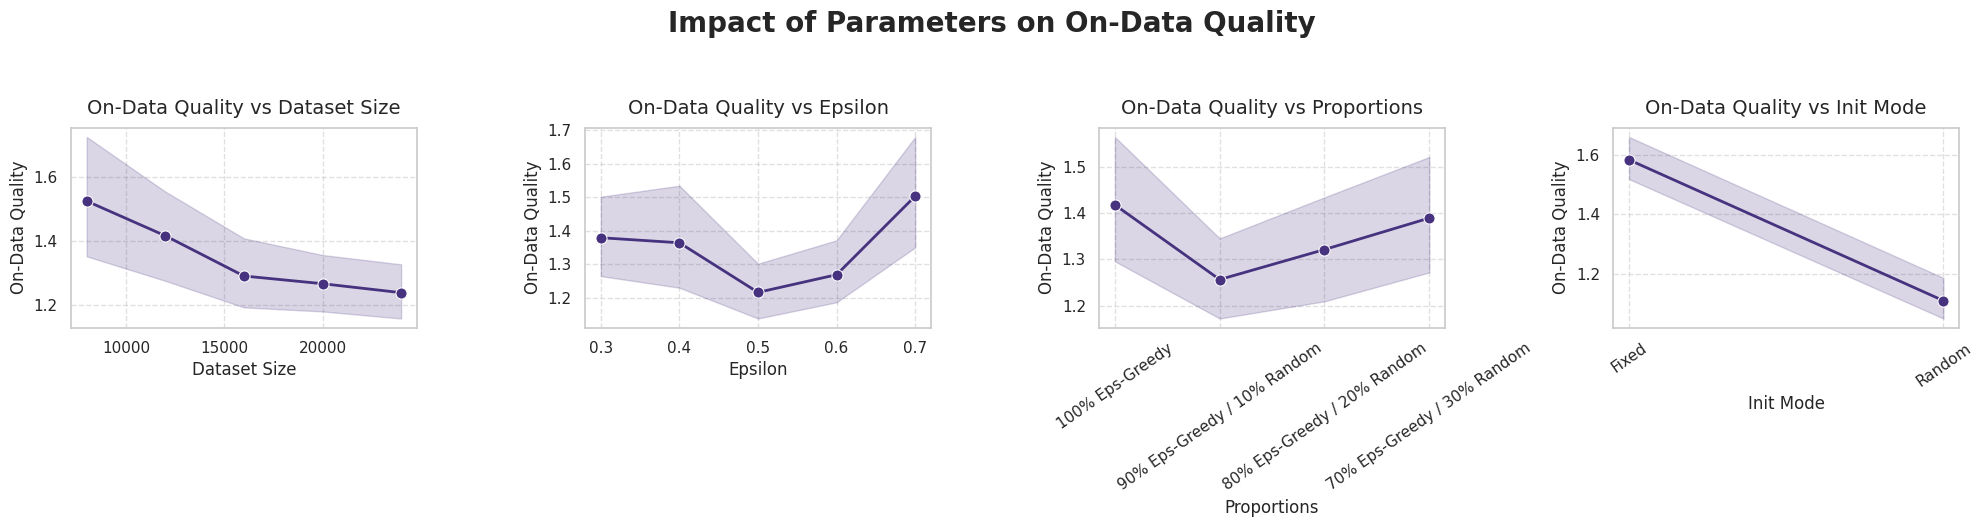

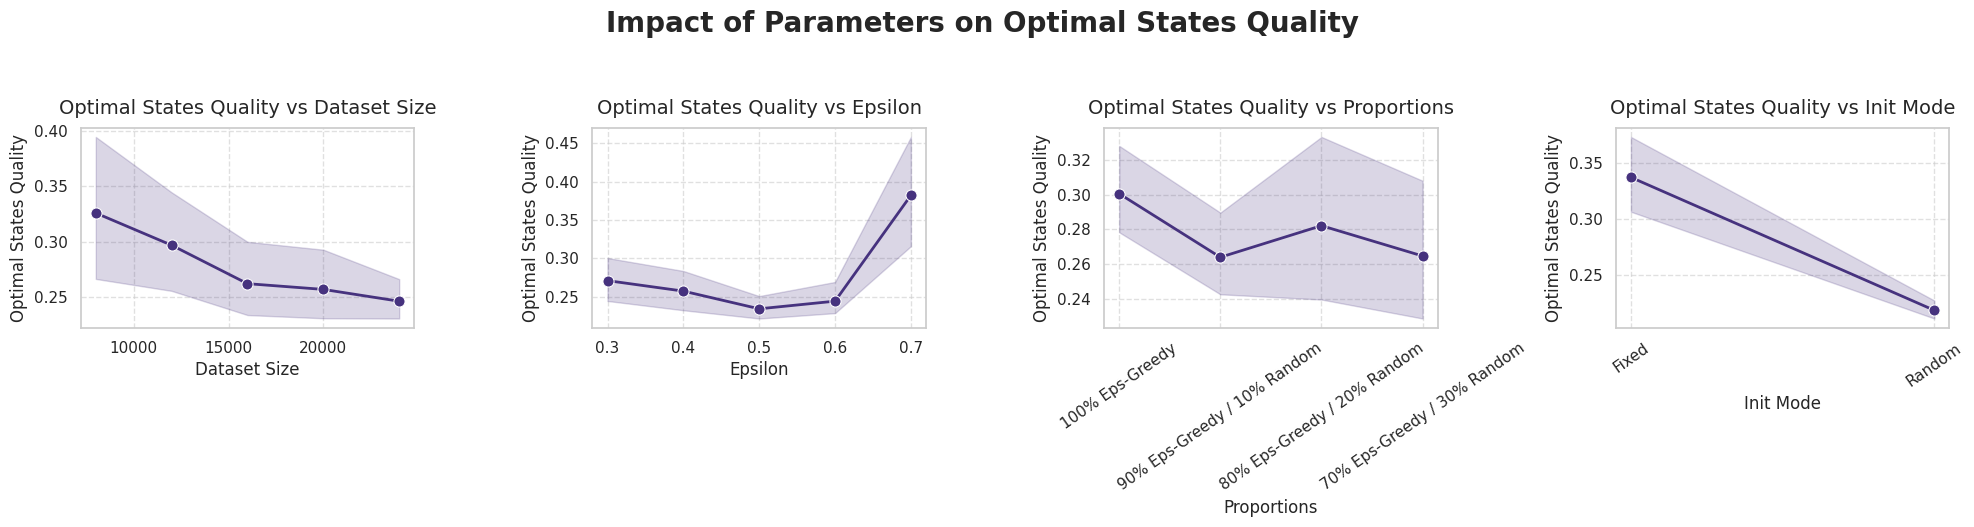

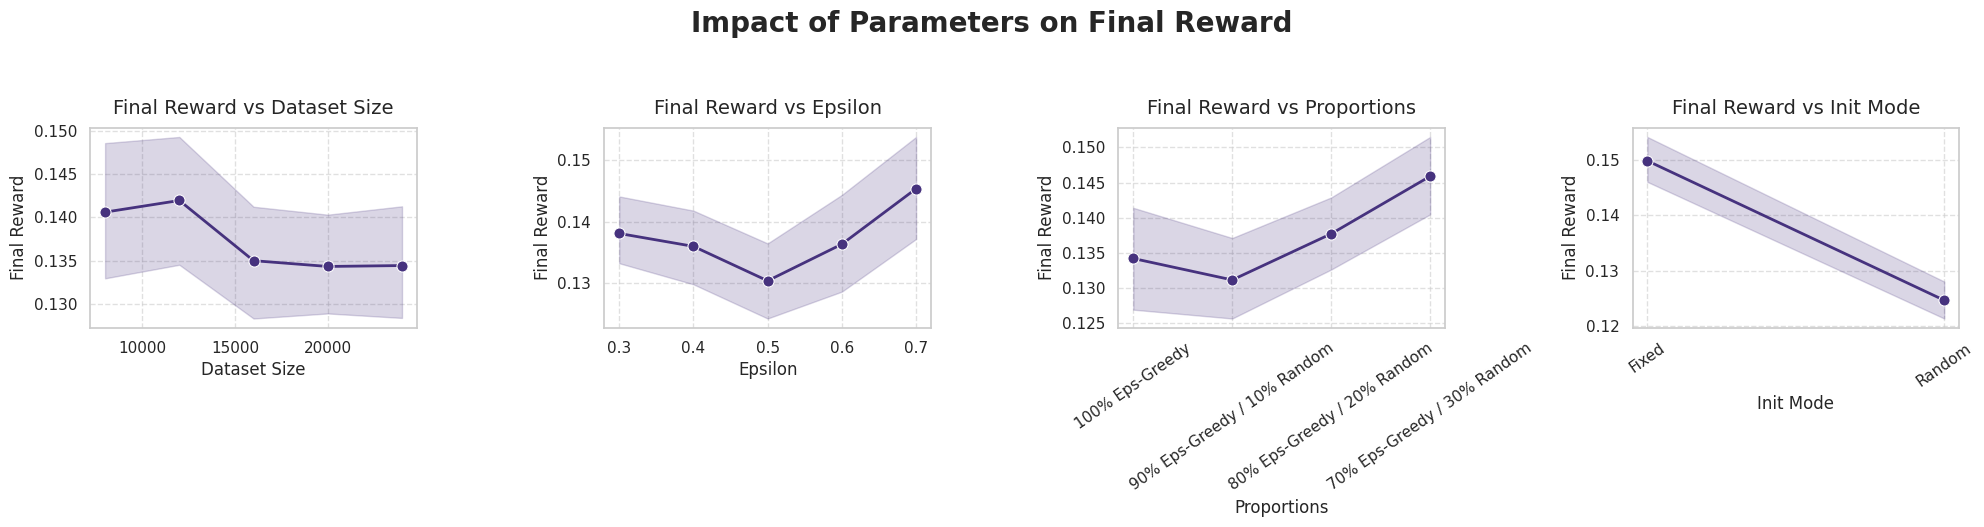

In [41]:
# Set premium aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.dpi'] = 100

# Define variables for analysis (Log Coverage removed, Reward is 'Final Reward')
x_vars = ["Dataset Size", "Epsilon", "Proportions", "Init Mode"]
y_vars = ["On-Data Quality", "Optimal States Quality", "Final Reward"]

print("📊 Generating Performance Analysis Plots...")

# Create one row of plots for each Y metric
for y_var in y_vars:
    if y_var not in df_results.columns:
        print(f"⚠️ Warning: {y_var} not found in results dataframe.")
        continue
        
    fig, axes = plt.subplots(1, len(x_vars), figsize=(20, 5))
    fig.suptitle(f'Impact of Parameters on {y_var}', fontsize=20, y=1.05, fontweight='bold')
    
    for i, x_var in enumerate(x_vars):
        if x_var in df_results.columns:
            # Create the line plot
            sns.lineplot(
                data=df_results, 
                x=x_var, 
                y=y_var, 
                marker='o', 
                markersize=8,
                linewidth=2,
                err_style="band", 
                ax=axes[i]
            )
            
            # Styling
            axes[i].set_title(f'{y_var} vs {x_var}', fontsize=14, pad=10)
            axes[i].grid(True, linestyle="--", alpha=0.6)
            
            # Handle rotation for categorical-like labels
            if x_var in ["Proportions", "Init Mode"]:
                axes[i].tick_params(axis='x', rotation=35)
        else:
            axes[i].set_visible(False)
            
    plt.tight_layout()
    plt.show()

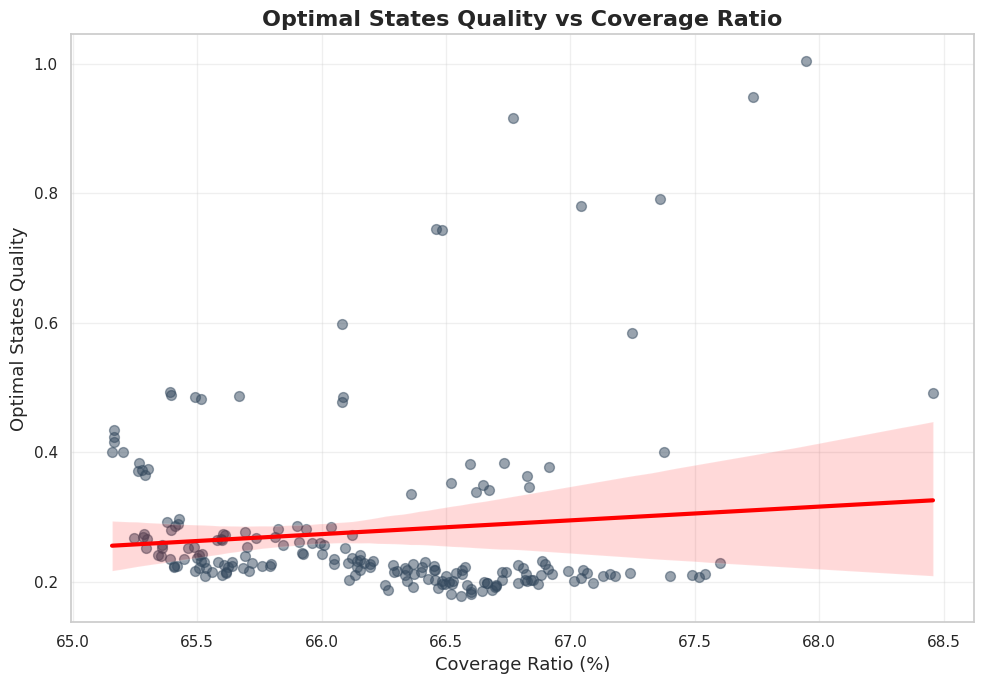

In [36]:
# 1. Prepare Data
df_plot = df_results.copy()

# 2. Create single visualization showing Coverage → Optimal States Quality relationship
plt.figure(figsize=(10, 7))

# --- Plot: Scatter plot with ALL data points + regression line ---
sns.regplot(data=df_plot, x='Coverage Ratio', y='Optimal States Quality', 
            scatter_kws={'alpha': 0.5, 's': 50, 'color': '#34495e'}, 
            line_kws={'color': 'red', 'linewidth': 3})

plt.title('Optimal States Quality vs Coverage Ratio', fontsize=16, fontweight='bold')
plt.xlabel('Coverage Ratio (%)', fontsize=13)
plt.ylabel('Optimal States Quality', fontsize=13)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1801214/1304286994.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


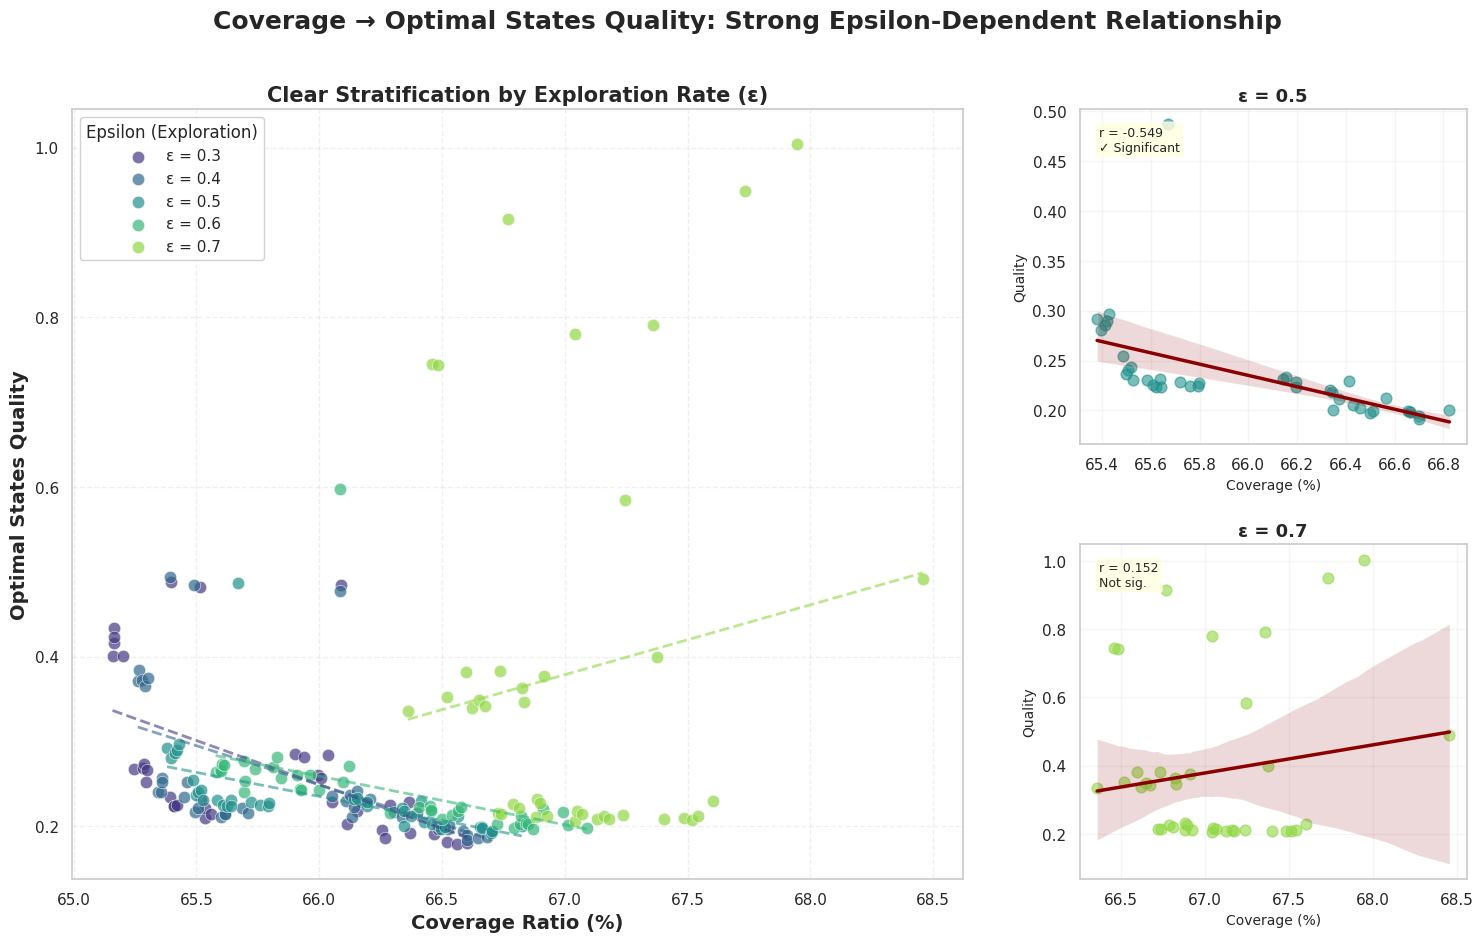

📊 COVERAGE → OPTIMAL STATES QUALITY ANALYSIS

Correlation by Epsilon:
--------------------------------------------------
  ε = 0.3:  r = -0.543  |  p = 0.0003  ✓
  ε = 0.4:  r = -0.547  |  p = 0.0003  ✓
  ε = 0.5:  r = -0.549  |  p = 0.0002  ✓
  ε = 0.6:  r = -0.445  |  p = 0.0040  ✓
  ε = 0.7:  r =  0.152  |  p = 0.3497  ✗

KEY FINDING: Higher epsilon → Higher coverage → Better quality!


In [37]:
# 1. Prepare Data
df_plot = df_results.copy()

# 2. Create focused visualization emphasizing the clear relationship
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Coverage → Optimal States Quality: Strong Epsilon-Dependent Relationship', 
             fontsize=18, fontweight='bold', y=0.98)

# --- Main Plot: Large scatter colored by Epsilon ---
ax_main = fig.add_subplot(gs[:, 0:2])

# Create a color palette
epsilon_values = sorted(df_plot['Epsilon'].unique())
colors = sns.color_palette("viridis", n_colors=len(epsilon_values))
epsilon_colors = {eps: colors[i] for i, eps in enumerate(epsilon_values)}

for eps_val in epsilon_values:
    subset = df_plot[df_plot['Epsilon'] == eps_val].sort_values('Coverage Ratio')
    ax_main.scatter(subset['Coverage Ratio'], subset['Optimal States Quality'], 
                   label=f'ε = {eps_val}', alpha=0.7, s=80, 
                   color=epsilon_colors[eps_val], edgecolors='white', linewidth=0.5)
    
    # Add trend line for each epsilon
    if len(subset) > 2:
        z = np.polyfit(subset['Coverage Ratio'], subset['Optimal States Quality'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Coverage Ratio'].min(), subset['Coverage Ratio'].max(), 100)
        ax_main.plot(x_line, p(x_line), '--', color=epsilon_colors[eps_val], 
                    alpha=0.6, linewidth=2)

ax_main.set_xlabel('Coverage Ratio (%)', fontsize=14, fontweight='bold')
ax_main.set_ylabel('Optimal States Quality', fontsize=14, fontweight='bold')
ax_main.set_title('Clear Stratification by Exploration Rate (ε)', fontsize=15, fontweight='bold')
ax_main.legend(title='Epsilon (Exploration)', loc='upper left', fontsize=11, 
              title_fontsize=12, framealpha=0.9)
ax_main.grid(alpha=0.3, linestyle='--')

# --- Right panels: Individual epsilon correlations ---
right_positions = [(0, 2), (1, 2)]  # Only use column 2, rows 0 and 1

for idx, eps_val in enumerate([0.5, 0.7]):  # Show the two clearest examples
    row, col = right_positions[idx]
    ax = fig.add_subplot(gs[row, col])
    
    subset = df_plot[df_plot['Epsilon'] == eps_val]
    
    # Regression plot
    sns.regplot(data=subset, x='Coverage Ratio', y='Optimal States Quality',
                scatter_kws={'alpha': 0.6, 's': 60, 'color': epsilon_colors[eps_val]},
                line_kws={'color': 'darkred', 'linewidth': 2.5},
                ax=ax)
    
    # Calculate correlation
    corr, p_val = pearsonr(subset['Coverage Ratio'], subset['Optimal States Quality'])
    
    ax.set_title(f'ε = {eps_val}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Coverage (%)', fontsize=10)
    ax.set_ylabel('Quality', fontsize=10)
    
    # Add stats box
    sig = "✓ Significant" if p_val < 0.05 else "Not sig."
    ax.text(0.05, 0.95, f'r = {corr:.3f}\n{sig}', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 70)
print("📊 COVERAGE → OPTIMAL STATES QUALITY ANALYSIS")
print("=" * 70)
print("\nCorrelation by Epsilon:")
print("-" * 50)
for eps_val in epsilon_values:
    subset = df_plot[df_plot['Epsilon'] == eps_val]
    corr, p_val = pearsonr(subset['Coverage Ratio'], subset['Optimal States Quality'])
    sig = "✓" if p_val < 0.05 else "✗"
    print(f"  ε = {eps_val}:  r = {corr:6.3f}  |  p = {p_val:.4f}  {sig}")

print("\n" + "=" * 70)
print("KEY FINDING: Higher epsilon → Higher coverage → Better quality!")
print("=" * 70)

## Linear Fitted Q-Iteration

Given an offline batch dataset $\mathcal{D}={(x_i,a_i,r_i,x_i')}_{i=1}^n$, this version of (linear) FQI does:

1. **Build targets using current Q estimate**
   $$
   y_i^{(k)} = r_i + \gamma \max_{a'} Q_{\theta_k}(x'_i, a')
   $$

2. **Fit a new Q-function to those targets** by regression on $(x_i,a_i)$
   $$
   \theta_{k+1}^{+}
   = \arg\min_\theta \sum_{i=1}^n \left(y_i^{(k)} - \phi(x_i,a_i)^\top\theta\right)^2 + \lambda|\theta|_2^2
   $$

3. (Optional) **soft update**:
   $$
   \theta_{k+1} = \tau,\theta_k + (1-\tau),\theta_{k+1}^{+}
   $$

LEt's try first with the dataset of FOGAS:

In [3]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed,
    ridge=1e-2 
)
evaluator_fqi = FQIEvaluator(solver_fqi)

In [4]:
pi_fqi = solver_fqi.run(
    K=1000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=30)

FQI: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1602.10it/s, theta_norm=3.8244]



FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 1.00  π(a=3|s=1) = 0.00  --> best action: 2
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 1.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 1.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 0.00  --> best action: 1
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 1.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 0.00  --> best action: 1
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 1.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 0.00  --> best

Now lets create a dataset with full coverage:

In [5]:
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Configure the probabilities: 
# 80% of trajectories start in a random "safe" state
# 20% of trajectories start in the fixed initial state (x0)
reset_options = {
    'random': 0.8, 
    'x0': 0.2
}

# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    restricted_states=walls,  # These will never be starting states
    terminal_states=list(pits) + (goal if isinstance(goal, list) else [goal]), # Terminal states are also excluded
    reset_probs=reset_options,
    max_steps=50
)
DATASET_PATH2 = PROJECT_ROOT / "datasets" / "10grid_wall_fqi.csv"

collector.collect_dataset_terminal_aware(
    n_steps=20000, extra_steps=5, save_path=str(DATASET_PATH2), verbose=True
)

✅ Terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_wall_fqi.csv
   Total transitions: 20000


,episode,step,state,action,reward,next_state
0,0,0,3,0,-0.1,3
1,0,1,3,3,-0.1,3
2,0,2,3,2,-0.1,2
3,0,3,2,1,-0.1,12
4,0,4,12,1,-0.1,12
...,...,...,...,...,...,...
19995,627,44,41,0,-0.1,31
19996,627,45,31,0,-0.1,31
19997,627,46,31,1,-0.1,41
19998,627,47,41,1,-0.1,51


In [8]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp,
    csv_path=str(DATASET_PATH2),
    device=device,
    seed=seed,
    ridge=1e-2 
)
evaluator_fqi = FQIEvaluator(solver_fqi)
pi_fqi = solver_fqi.run(
    K=5000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=24)

FQI: 100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 732.58it/s, theta_norm=285.0963]



FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 1.00  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 1.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 1.00  --> best

### GRID-SEARCH FQI

In [18]:
DATASET_PATH_FQI = PROJECT_ROOT / "datasets" / 'fqi_grid_search_results.csv'

In [ ]:
# Fixed environment parameters
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Fixed FQI solver parameters
FQI_PARAMS = {
    'K': 5000,
    'tau': 0.1,
    'ridge': 1e-2,
    'verbose': False
}

# Grid search parameters
reset_configs = {
    "80/20": {'random': 0.8, 'x0': 0.2},
    "60/40": {'random': 0.6, 'x0': 0.4},
    "50/50": {'random': 0.5, 'x0': 0.5},
    "100/0": {'random': 1.0, 'x0': 0.0},
    "0/100": {'random': 0.0, 'x0': 1.0},
}

extra_steps_values = [0, 1, 3, 5]
dataset_sizes = [10000, 15000, 20000, 25000, 30000]

beta_val = 1e-2

# Setup
temp_dir = "temp_fqi_grid_search"
os.makedirs(temp_dir, exist_ok=True)

results = []
total_iters = len(reset_configs) * len(extra_steps_values) * len(dataset_sizes)

print(f"🚀 Starting FQI Grid Search ({total_iters} scenarios)...")
print(f"   Varying: reset probabilities, extra_steps, dataset size")
print(f"   Computing: Task Success, Coverage Ratio\n")

# Grid search loop
with tqdm(total=total_iters, desc="FQI Grid Searching") as pbar:
    for reset_label, reset_probs in reset_configs.items():
        for extra_steps in extra_steps_values:
            for n_steps in dataset_sizes:
                fname = f"fqi_{reset_label}_extra{extra_steps}_n{n_steps}.csv"
                save_path = os.path.join(temp_dir, fname)
                
                # A. Collect Dataset
                try:
                    collector = EnvDataCollector(
                        mdp=mdp,
                        env_name="10grid_wall",
                        restricted_states=walls,
                        terminal_states=list(pits) + (goal if isinstance(goal, list) else [goal]),
                        reset_probs=reset_probs,
                        max_steps=50,
                        seed=seed
                    )
                    
                    collector.collect_dataset_terminal_aware(
                        n_steps=n_steps,
                        extra_steps=extra_steps,
                        save_path=save_path,
                        verbose=False
                    )
                except Exception as e:
                    print(f"\n⚠️  Dataset collection failed: {e}")
                    pbar.update(1)
                    continue
                
                # B. Analyze Feature Coverage
                try:
                    analyzer = DatasetAnalyzer(save_path)
                    coverage_ratio = analyzer.feature_coverage_ratio(
                        mdp=mdp, beta=beta_val, use_optimal_policy=True, verbose=False
                    )
                except:
                    coverage_ratio = np.nan
                
                # C. Train FQI and Evaluate
                try:
                    # Initialize FQI Solver
                    solver_fqi = FQISolver(
                        mdp=mdp,
                        csv_path=save_path,
                        device=device,
                        seed=seed,
                        ridge=FQI_PARAMS['ridge']
                    )
                    
                    # Run FQI
                    pi_fqi = solver_fqi.run(
                        K=FQI_PARAMS['K'],
                        tau=FQI_PARAMS['tau'],
                        verbose=FQI_PARAMS['verbose']
                    )
                    
                    # Evaluate
                    evaluator_fqi = FQIEvaluator(solver_fqi)
                    task_success = evaluator_fqi.final_reward()
                    
                    # Check convergence (if solver tracks this)
                    converged = evaluator_fqi.converged()
                    
                except Exception as e:
                    print(f"\n⚠️  FQI training/evaluation failed: {e}")
                    task_success = np.nan
                    converged = False
                
                # Store results
                results.append({
                    "Reset Config": reset_label,
                    "Extra Steps": extra_steps,
                    "Dataset Size": n_steps,
                    "Coverage Ratio": coverage_ratio,
                    "Log Coverage": np.log10(coverage_ratio) if coverage_ratio > 0 else np.nan,
                    "Task Success": task_success,
                    "Converged": converged,
                })
                
                # Cleanup
                if os.path.exists(save_path):
                    os.remove(save_path)
                pbar.update(1)

# Cleanup temp directory
if os.path.exists(temp_dir):
    try:
        os.rmdir(temp_dir)
    except:
        pass

# Create results dataframe
df_fqi_results = pd.DataFrame(results)

print("\n✅ FQI Grid Search Complete!")
print(f"   Total scenarios: {len(df_fqi_results)}")
print(f"   Successful runs: {df_fqi_results['Task Success'].notna().sum()}")
print(f"   Failed runs: {df_fqi_results['Task Success'].isna().sum()}")
if 'Converged' in df_fqi_results.columns:
    print(f"   Converged runs: {df_fqi_results['Converged'].sum()}\n")

# Display results
display(df_fqi_results.head(10))

# Save results
df_fqi_results.to_csv(str(DATASET_PATH_FQI), index=False)
print("✅ Results saved to ", DATASET_PATH_FQI)

# Summary statistics
print("\n" + "="*70)
print("  FQI GRID SEARCH SUMMARY")
print("="*70 + "\n")

print("Coverage Ratio Statistics:")
valid_coverage = df_fqi_results['Coverage Ratio'].dropna()
if len(valid_coverage) > 0:
    print(f"  Mean:   {valid_coverage.mean():.6f}")
    print(f"  Median: {valid_coverage.median():.6f}")
    print(f"  Min:    {valid_coverage.min():.6f}")
    print(f"  Max:    {valid_coverage.max():.6f}\n")

print("Task Success Statistics:")
valid_data = df_fqi_results['Task Success'].dropna()
if len(valid_data) > 0:
    print(f"  Mean:   {valid_data.mean():.6f}")
    print(f"  Median: {valid_data.median():.6f}")
    print(f"  Std:    {valid_data.std():.6f}")
    print(f"  Min:    {valid_data.min():.6f}")
    print(f"  Max:    {valid_data.max():.6f}\n")

# Best configurations
print("Top 5 Configurations by Task Success:")
top_configs = df_fqi_results.nlargest(5, 'Task Success')[
    ['Reset Config', 'Extra Steps', 'Dataset Size', 'Coverage Ratio', 'Task Success', 'Converged']
]
print(top_configs.to_string(index=False))
print("\n" + "="*70)

If already done, download the results from the grid search job.

In [19]:
df_fqi_results = pd.read_csv(DATASET_PATH_FQI)

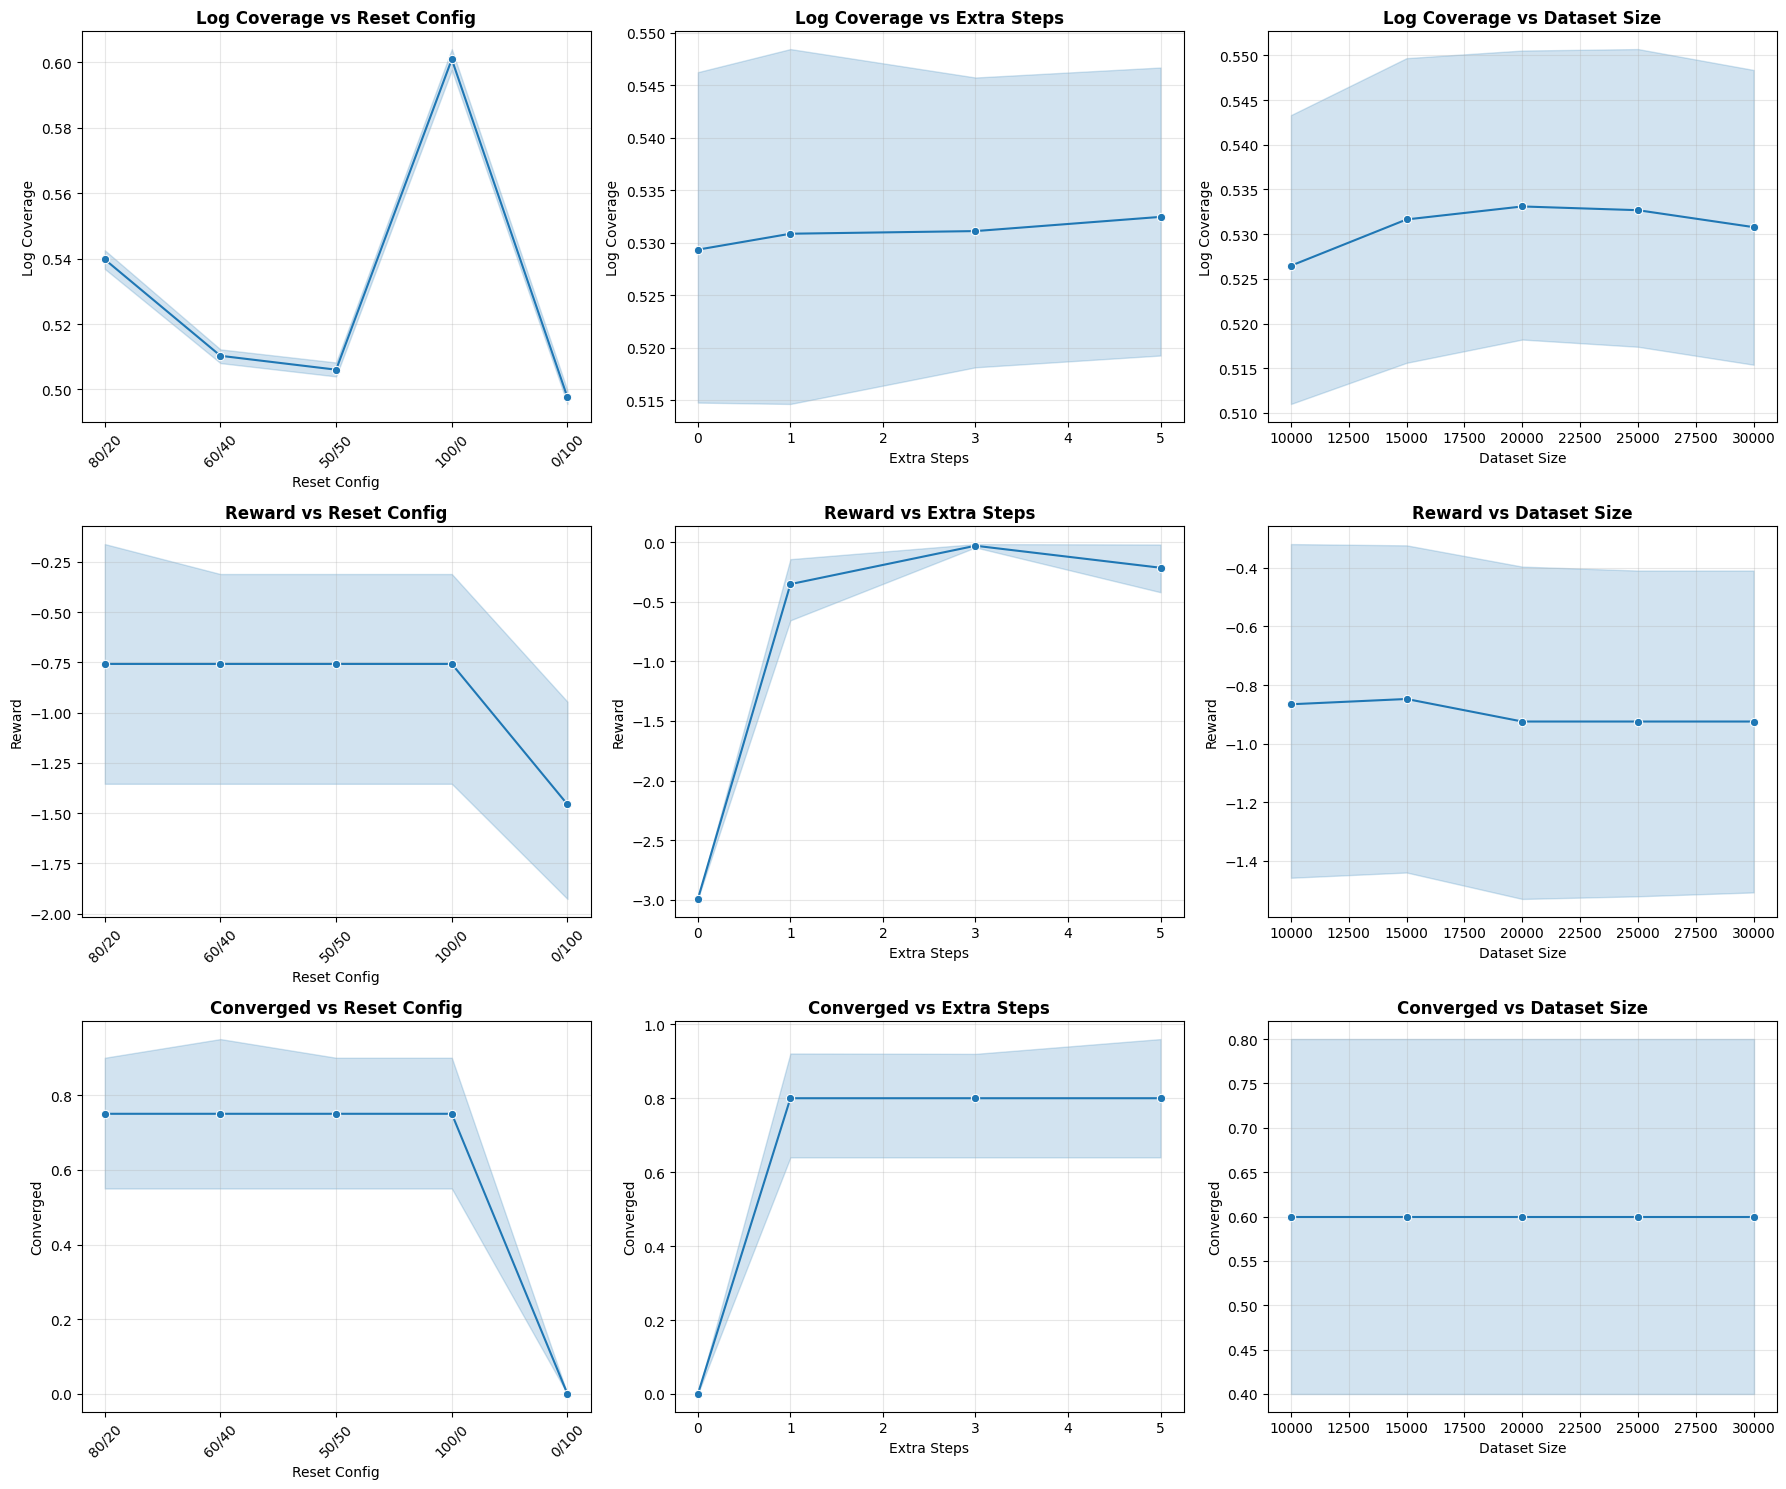

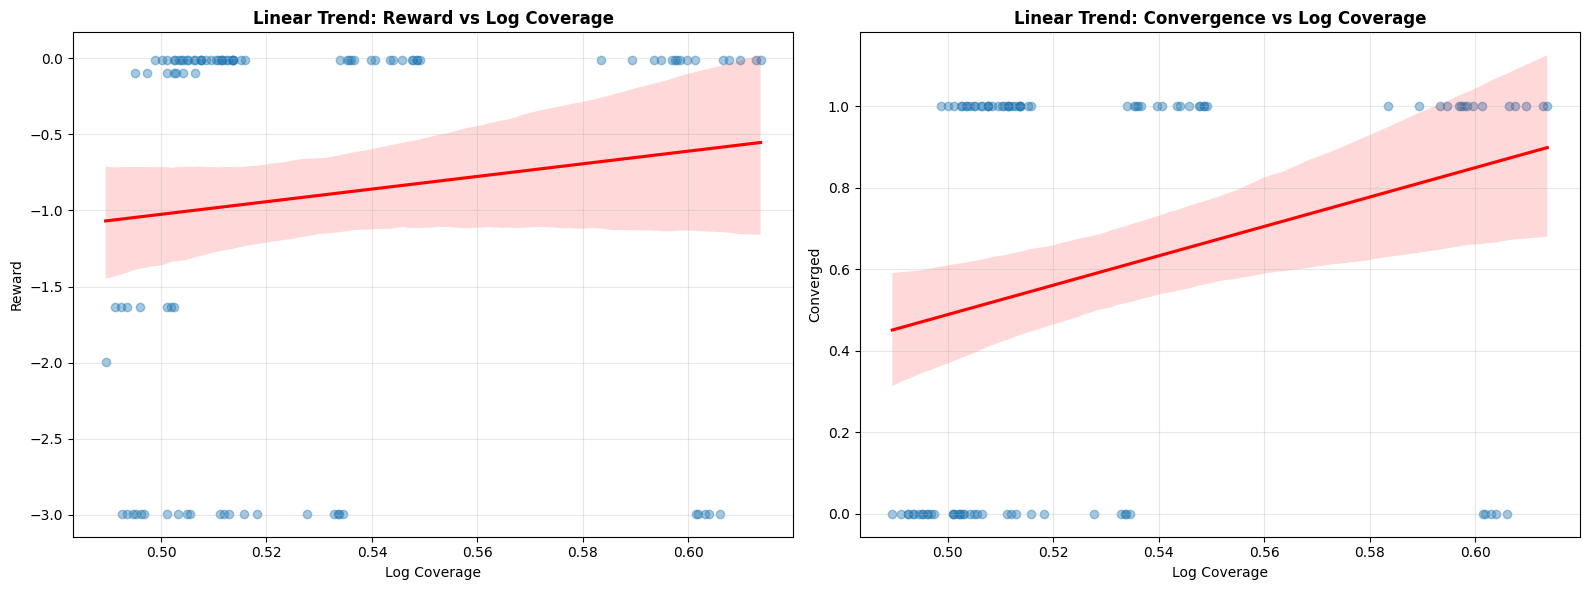

In [17]:
# 1. Prepare the dataframe: rename column and ensure metrics are numeric
df_plot = df_fqi_results.copy()
if 'Task Success' in df_plot.columns:
    df_plot = df_plot.rename(columns={'Task Success': 'Reward'})
# 2. Define our axes
variables = ['Reset Config', 'Extra Steps', 'Dataset Size']
metrics = ['Log Coverage', 'Reward', 'Converged']
# 3. Create the 3x3 Grid (Linear Trends vs Independent Variables)
fig, axes = plt.subplots(len(metrics), len(variables), figsize=(18, 15))
for i, metric in enumerate(metrics):
    for j, var in enumerate(variables):
        ax = axes[i, j]
        # Using lineplot for the categorical/discrete summary
        sns.lineplot(data=df_plot, x=var, y=metric, marker='o', ax=ax)
        
        ax.set_title(f'{metric} vs {var}', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if var == 'Reset Config':
            ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
# 4. RELATIONSHIP ANALYSIS (Linear Trend)
# Replacing the scatter plot with the regplots you preferred
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot A: Linear Trend of Reward vs Log Coverage
sns.regplot(data=df_plot, x='Log Coverage', y='Reward', ax=axes[0], 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axes[0].set_title('Linear Trend: Reward vs Log Coverage', fontweight='bold')
axes[0].grid(True, alpha=0.3)
# Plot B: Linear Trend of Convergence vs Log Coverage
sns.regplot(data=df_plot, x='Log Coverage', y='Converged', ax=axes[1], 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axes[1].set_title('Linear Trend: Convergence vs Log Coverage', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()